In [9]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import warnings
import sys
sys.path.append('..')
from utils import plot_iters,plot_coverage_all
warnings.filterwarnings("ignore")
# import ot
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

In [2]:
import pandas as pd
data = pd.read_csv('https://xiongpengnus.github.io/rsome/taxi_rain.csv')
demand = data.loc[:, 'Region1':'Region10']  
data = demand.values                              # sample demand as an array
d_ub = demand.max().values                      # upper bound of demand
d_lb = demand.min().values 
# S = dhat.shape[0]  
I, J = 1, 10
r = np.array([4.50, 4.41, 3.61, 4.49, 4.38, 4.58, 4.53, 4.64, 4.58, 4.32])
c = 3 * np.ones(J)
q = 400 * np.ones(I)

y_data = []
for i in range(10):
    y_data.append(r + np.random.normal(0,0.1,J))
y_data = np.array(y_data)

In [3]:

def f_tch(t, x, y, Y, r, u):
    # x is a tensor that represents the cp.Variable x.
    return t

def g_tch1(t, x, y, Y, r, u):
    # x,y,u are tensors that represent the cp.Variable x and cp.Parameter y and 
    # The cp.Constant c is converted to a tensor
    return (torch.tensor(c)-r)@x + r@y + r@Y@u.T - t

funcs = [g_tch1]
for i in range(J):
  def g(t, x, y, Y, r, u, i=i):
    return x[i] - (Y[i]+torch.eye(J)[i])@u.T - y[i]
  funcs.append(g)

for i in range(J):
  def g(t, x, y, Y, r, u, i=i):
    return -y[i] - Y[i]@u.T
  funcs.append(g)
    
def eval_tch(t, x, y, Y, r, u):
    return (torch.tensor(c)-r)@x + r@y + r@Y@u.T

In [13]:
D = np.vstack([np.eye(J),-np.eye(J)])
d = np.hstack([d_ub, -d_lb])
u = lropt.UncertainParameter(J,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, rho = 20, c=D,d=d))
# Formulate the Robust Problem
x = cp.Variable(J)
r = lropt.Parameter(J, data = y_data)
y = cp.Variable(J)
Y = cp.Variable((J,J))
t = cp.Variable()
r.value = y_data[0]
objective = cp.Minimize(t)
constraints = [(c-r)@x + r@y + r@Y@u <= t]
for i in range(J):
    constraints += [y[i] >= x[i] - (Y[i]+np.eye(J)[i])@u]
    constraints += [y[i] + Y[i]@u >= 0]
constraints += [x >= 0, cp.sum(x)<= q]
prob = lropt.RobustProblem(objective, constraints,objective_torch=f_tch, constraints_torch=funcs, eval_torch=eval_tch)


target = -0.05
test_p = 0.5
s = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T))) + np.eye(J)
# init = np.eye(J)
init_bval = -init@np.mean(train, axis=0)
np.random.seed(18)
initn = 0.01*init + 0.01*np.random.rand(J, J)
init_bvaln = -initn@np.mean(train, axis=0)
0
# Train A and b
result1 = prob.train(lr = 0.0001, num_iter=1000, momentum = 0.8, optimizer = "SGD", seed = s, init_eps = 2, init_A = 0.1*init, init_b = 0.1*init_bval, init_lam = 1, init_mu = 0.01, mu_multiplier = 1.005, kappa  = target, init_alpha = -0.005, test_percentage = test_p, position = False, parallel = True, random_init = True, num_random_init = 5)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

run 0: test value -66.76, violations 1.0: 100%|██████████| 1000/1000 [11:43<00:00,  1.42it/s]


In [26]:
# Grid search epsilon
result4 = prob.grid(epslst = np.logspace(0,3.5,100), init_A = init, init_b = init_bval, seed = s, init_alpha = 0., test_percentage =test_p)
dfgrid = result4.df

In [19]:
result5 = prob.grid(epslst = np.logspace(0,2,100), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0., test_percentage = test_p)
dfgrid2 = result5.df

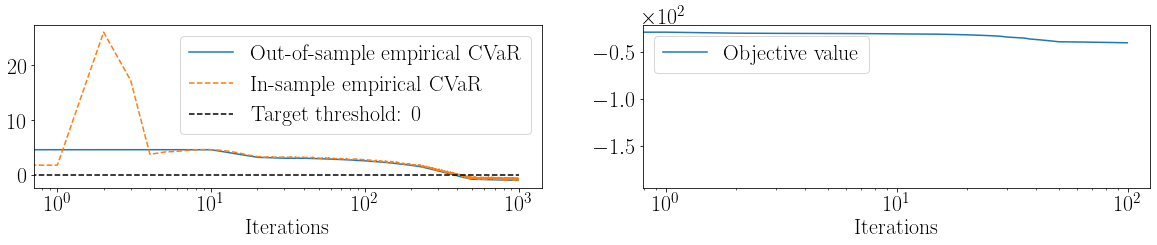

In [20]:
plot_iters(df1,result1.df_test,"allocation", steps = 3000)

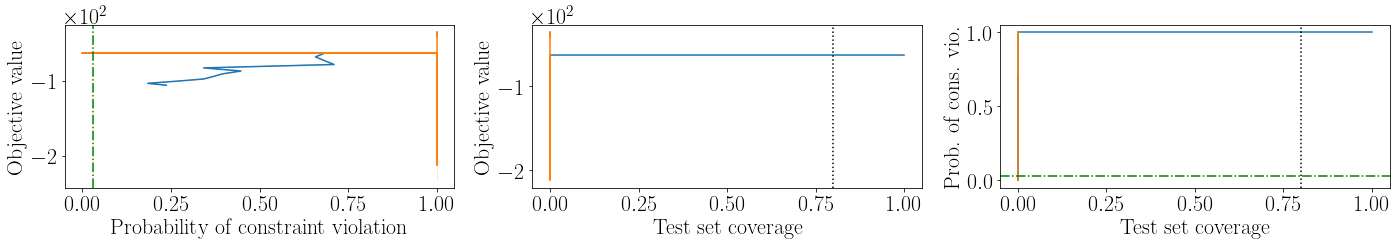

In [27]:
# seed 1
plot_coverage_all(dfgrid,dfgrid2,None, "allocation",ind_1=(0,3000),ind_2=(0,3000
), logscale = False)

In [ ]:
D = np.vstack([np.eye(J),-np.eye(J)])
d = np.hstack([d_ub, -d_lb])
u = lropt.UncertainParameter(J,
                        uncertainty_set=lropt.Polyhedral(D=D, d=d))
u = lropt.UncertainParameter(J,
                        uncertainty_set=lropt.Ellipsoidal(p=2, rho = 20, a = None, b=-np.mean(train, axis=0), c=D,d=d))
# Formulate the Robust Problem
x = cp.Variable(J)
r = cp.Parameter(J)
y = cp.Variable(J)
Y = cp.Variable((J,J))
t = cp.Variable()
r.value = y_data[0]
objective = cp.Minimize(t)
constraints = [(c-r)@x + r@y + r@Y@u <= t]
for i in range(J):
    constraints += [y[i] >= x[i] - (Y[i]+np.eye(J)[i])@u]
    constraints += [y[i] + Y[i]@u >= 0]
constraints += [x >= 0, cp.sum(x)<= q]
prob = lropt.RobustProblem(objective, constraints)
prob.solve(), x.value

(-95.67390875505001,
 array([1.46564287e-09, 1.45246007e-09, 9.72729475e-10, 1.56369684e-09,
        1.22814225e-09, 6.56814253e+01, 1.50836369e-09, 1.95423759e-09,
        1.69835675e-09, 1.39116149e-09]))

In [10]:
u = lropt.UncertainParameter(J,
                        uncertainty_set=lropt.MRO(train = False, data = data, rho = 20, a = None, K = 1, c = D, d = d))
# Formulate the Robust Problem
x = cp.Variable(J)
r = cp.Parameter(J)
y = cp.Variable(J)
Y = cp.Variable((J,J))
t = cp.Variable()
r.value = y_data[0]
objective = cp.Minimize(t)
constraints = [(c-r)@x + r@y + r@Y@u <= t]
for i in range(J):
    constraints += [y[i] >= x[i] - (Y[i]+np.eye(J)[i])@u]
    constraints += [y[i] + Y[i]@u >= 0]
constraints += [x >= 0, cp.sum(x)<= q]
prob = lropt.RobustProblem(objective, constraints)
prob.solve(), x.value

(-93.02835942162197,
 array([1.54232864e-09, 1.47822382e-09, 9.50809818e-10, 1.52357378e-09,
        1.23728994e-09, 6.38652201e+01, 1.54410602e-09, 1.96651964e-09,
        1.81726039e-09, 1.44768876e-09]))

In [146]:
np.vstack([np.ones(n), np.ones(n)]).T

True

In [118]:
a = [6,3,3,3]
b = [2,4,6,1]
zipped = zip(a,b)
res = sorted(zipped, key = lambda x: (x[0],x[1]))

In [3]:
import cvxpy as cp
x1 = cp.Variable()
x2 = cp.Variable()
objective = cp.Minimize(3*x1 + x2)
constraints = [cp.norm(3*x1)<= x2]
prob = cp.Problem(objective, constraints)
prob.solve()

-9.99472726803674e-10

In [4]:
x1 = cp.Variable()
x2 = cp.Variable()
objective = cp.Minimize(x1 + x2)
constraints = [cp.norm(x1)<= x2]
prob = cp.Problem(objective, constraints)
prob.solve()

-8.445408261614773e-10